## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({
    "font.size": 16,        # base font
    "axes.titlesize": 20,   # title
    "axes.labelsize": 18,   # x/y labels
    "xtick.labelsize": 16,  # x tick labels
    "ytick.labelsize": 16,  # y tick labels
    "legend.fontsize": 16,  # legend
})

## Parameters

In [2]:
sigma = 1.0  # Volatility
S0 = 100  # Initial price
q0 = 0      # Initial inventory
X0 = 0      # Initial cash
# k = 1
# j = 0.01    # Impact coefficient for prob function
gamma = 0.01  # Risk aversion penalty

## Specific functions

In [3]:
def f(x):
    return(1/2*np.exp(-x))

def Delta(lam):
    return max(0,lam+1)

def C(lam):
    if lam >= -1:
        return 1/2 * np.exp(-(lam+1))
    else:
        return -lam/2
    
def dp_step(q, V_qm1, V_q, V_qp1):
    return V_q - gamma/2 * q**2 + C(V_q - V_qm1) + C(V_q - V_qp1)

def fill_V(T):
    V = np.zeros((2*T+1, T+1))
    for n in reversed(range(T)):
        for q in range(T-n, T+n+1):
            V[q,n] = dp_step(q-T,V[q-1,n+1],V[q,n+1], V[q+1,n+1])
    return V


In [4]:
fill_V(4)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.32287944, 0.        ],
       [0.        , 0.        , 0.69399729, 0.34787944, 0.        ],
       [0.        , 1.08324061, 0.72394238, 0.36287944, 0.        ],
       [1.46058509, 1.09814972, 0.73392408, 0.36787944, 0.        ],
       [0.        , 1.08324061, 0.72394238, 0.36287944, 0.        ],
       [0.        , 0.        , 0.69399729, 0.34787944, 0.        ],
       [0.        , 0.        , 0.        , 0.32287944, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

## Main simulation functions

In [5]:
def run_market_simulation(V, T=100, sigma=1.0, S0=100, gamma=0.01):
    q = np.zeros(T+1, dtype=int)
    c = np.zeros(T+1)
    cash = np.zeros(T+1)
    pnl = np.zeros(T+1)
    S = np.zeros(T+1)
    S[0] = S0
    
    for n in range(T):  
        delta_a_opt = Delta(V[q[n]+T,n+1] - V[q[n]+T-1,n+1]) 
        delta_b_opt = Delta(V[q[n]+T,n+1] - V[q[n]+T+1,n+1])
        p_ask_opt = f(delta_a_opt)
        p_bid_opt = f(delta_b_opt)
        p_none_opt = 1 - p_ask_opt - p_bid_opt
        event_opt = np.random.choice(['ask', 'bid', 'none'], p=[p_ask_opt, p_bid_opt, p_none_opt])
        eta_a_opt = 1 if event_opt == 'ask' else 0
        eta_b_opt = 1 if event_opt == 'bid' else 0
        q[n+1] = q[n] - eta_a_opt + eta_b_opt
        cash[n+1] = cash[n] + eta_a_opt * (S[n] + delta_a_opt) - eta_b_opt * (S[n] - delta_b_opt)
        c[n] = delta_a_opt * eta_a_opt + delta_b_opt * eta_b_opt - gamma/2 * q[n]**2 #idea de Carlos *2
        pnl[n+1] = cash[n+1] + S[n] * q[n+1]
        S[n+1] = S[n]+np.random.normal(0,sigma)
    c_sum = sum(c)
    return c_sum, pnl, q


def simulate_multiple_runs(num_simulations=10000, T=100):
    sigma = 1.0
    S0 = 100
    gamma = 0.01
    V = fill_V(T)
    cs = np.zeros(num_simulations)
    pnls = np.zeros((num_simulations, T+1))
    qs = np.zeros((num_simulations, T+1))
    for i in range(num_simulations):
        cs[i], pnls[i, :], qs[i, :] = run_market_simulation(V, T, sigma, S0, gamma)
    return cs, pnls, qs



def run_market_simulation_with_deltas(V, T=100, sigma=1.0, S0=100):
    q = np.zeros(T + 1, dtype=int)
    cash = np.zeros(T + 1)
    S = np.zeros(T + 1)
    S[0] = S0

    delta_a = np.zeros(T)
    delta_b = np.zeros(T)
    ask_quote = np.zeros(T)
    bid_quote = np.zeros(T)

    for n in range(T):
        # optimal deltas from DP
        da = Delta(V[q[n] + T, n + 1] - V[q[n] + T - 1, n + 1])
        db = Delta(V[q[n] + T, n + 1] - V[q[n] + T + 1, n + 1])

        delta_a[n], delta_b[n] = da, db
        ask_quote[n] = S[n] + da
        bid_quote[n] = S[n] - db

        # fill probabilities + event
        p_ask = f(da)
        p_bid = f(db)
        p_none = max(0.0, 1.0 - p_ask - p_bid)

        event = np.random.choice(["ask", "bid", "none"], p=[p_ask, p_bid, p_none])
        eta_a = 1 if event == "ask" else 0
        eta_b = 1 if event == "bid" else 0

        # inventory + cash updates
        q[n + 1] = q[n] - eta_a + eta_b
        cash[n + 1] = cash[n] + eta_a * (S[n] + da) - eta_b * (S[n] - db)

        # price evolution
        S[n + 1] = S[n] + np.random.normal(0, sigma)

    return S, q, delta_a, delta_b, ask_quote, bid_quote

Add indicator to probability and say we can only go down.

In [6]:
fill_V(3)

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.34787944, 0.        ],
       [0.        , 0.72394238, 0.36287944, 0.        ],
       [1.09814972, 0.73392408, 0.36787944, 0.        ],
       [0.        , 0.72394238, 0.36287944, 0.        ],
       [0.        , 0.        , 0.34787944, 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

## Simulation Results

In [7]:
T = 30
V = fill_V(T=T)
cs, pnls, qs = simulate_multiple_runs(num_simulations=10000, T=T)

In [8]:
print("Mean total cost over simulations:", np.mean(cs))
print("Optimal total cost:", V[T,0])
print("Relative error:", np.round(np.abs(np.mean(cs) - V[T,0]) / np.abs(V[T,0]) * 100, 2), "%")

Mean total cost over simulations: 10.54599265358402
Optimal total cost: 10.47863194925423
Relative error: 0.64 %


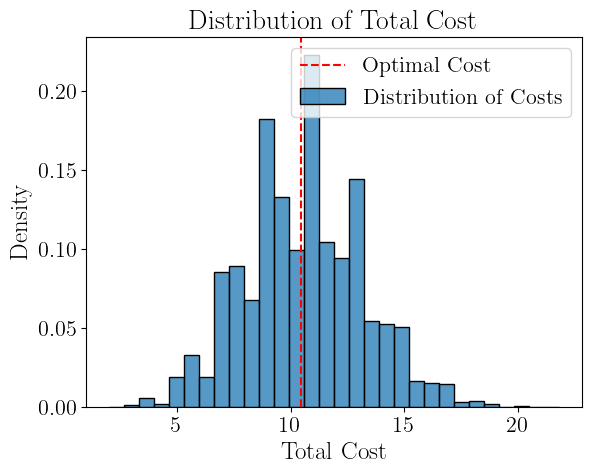

In [9]:
ax = sns.histplot(cs, bins=30, label="Distribution of Costs", stat='density')
ax.axvline(fill_V(T=T)[T,0], color='r', linestyle='--', label='Optimal Cost')
ax.set_title('Distribution of Total Cost')
ax.set_xlabel('Total Cost')
ax.set_ylabel('Density')
ax.legend()
plt.show()

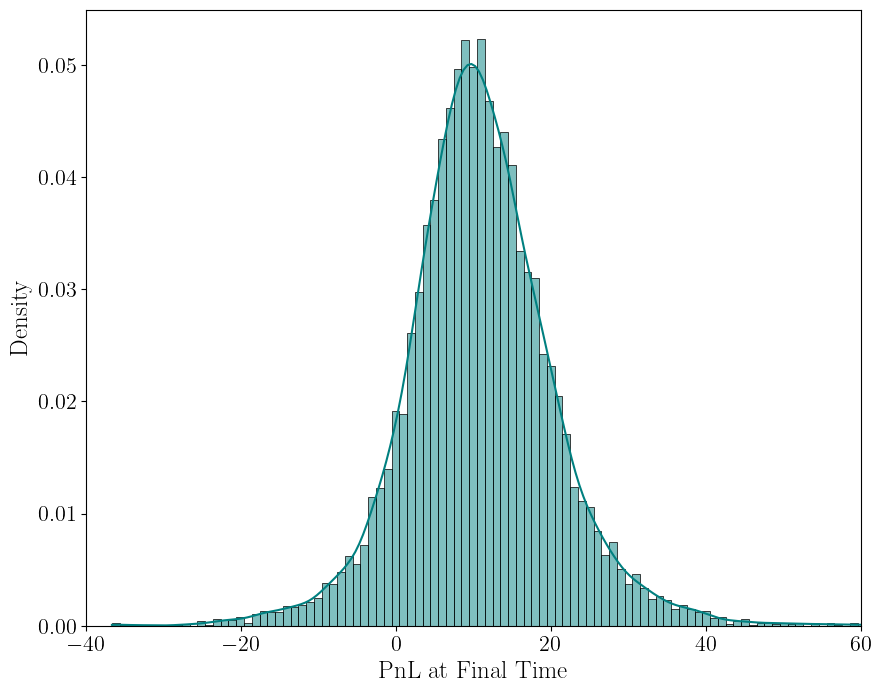

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.histplot(pnls[:, -1], bins='auto', color="teal", label="Distribution of PnL", stat='density', kde=True)
# ax.set_title('Distribution of PnL at Final Time')
ax.set_xlabel('PnL at Final Time')
ax.set_ylabel('Density')
ax.set_xlim(-40,60)
# ax.legend()
plt.savefig("Plots/pnl_distribution.png", dpi=300)
plt.show()

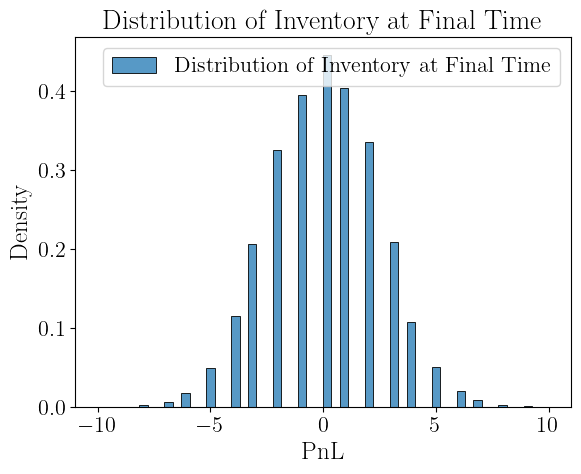

In [11]:
ax = sns.histplot(qs[:, -1], bins='auto', label="Distribution of Inventory at Final Time", stat='density')
ax.set_title('Distribution of Inventory at Final Time')
ax.set_xlabel('PnL')
ax.set_ylabel('Density')
ax.legend()
plt.show()

/var/folders/hr/wt83vx857tb5stw6bpqw6ss00000gn/T/ipykernel_42496/181393902.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


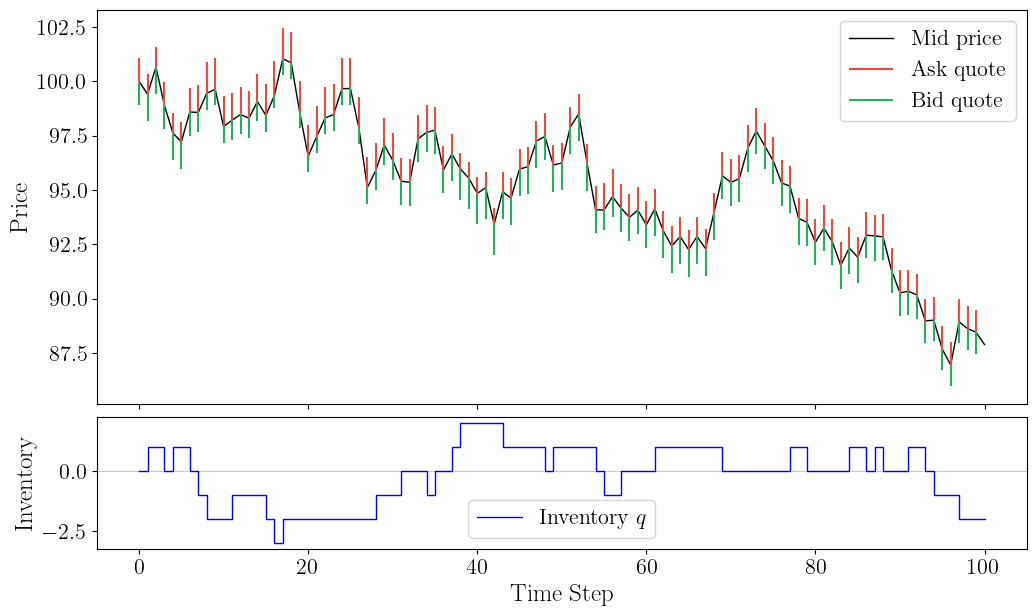

In [ ]:
T = 100
V = fill_V(T)
ASK_COLOR = "#E74C3C"
BID_COLOR = "#27AE60"

S, q_path, da, db, ask_q, bid_q = run_market_simulation_with_deltas(V, T=T, sigma=sigma, S0=S0)
t = np.arange(T + 1)
tq = np.arange(T)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 7),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# --- Top: price + quote flags ---
ax1.plot(t, S, linewidth=1, label="Mid price", color="black")
ax1.vlines(tq, S[:-1], ask_q, linewidth=1.5, color=ASK_COLOR, label="Ask quote")
ax1.vlines(tq, bid_q, S[:-1], linewidth=1.5, color=BID_COLOR, label="Bid quote")
ax1.set_ylabel("Price")
# ax1.set_title("Optimal quotes as flags on the asset price")
ax1.legend(loc="best")

# --- Bottom: inventory ---
ax2.step(t, q_path, where="post", linewidth=1.0, color="blue", label=r"Inventory $q$")
ax2.axhline(0, linewidth=.5, color="black", alpha=0.3)
ax2.set_ylabel("Inventory")
ax2.set_xlabel("Time Step")
ax2.legend(loc="best")

fig.tight_layout()
plt.show()
fig.savefig("Plots/optimal_quotes_inventory.png", dpi=300)


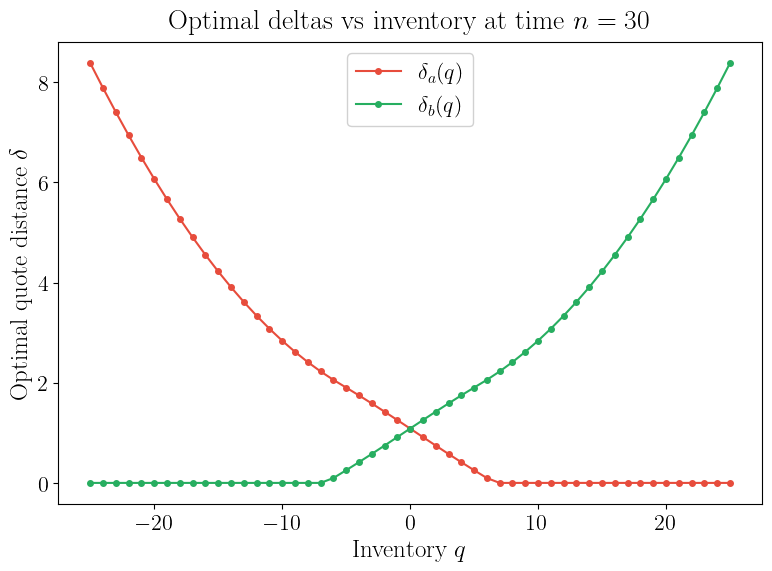

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deltas_vs_inventory_at_time(V, n, T, qmax=None, make_plot=True):
    """
    For fixed time n, compute deltas on a grid q in [-qmax, qmax]
    """
    if qmax is None:
        qmax = min(n, T-1)

    # Stay inside DP feasible inventory region at time n+1 (because deltas use V[:, n+1])
    qmax = int(min(qmax, n, T-1))

    qs = np.arange(-qmax, qmax + 1)

    da = np.array([Delta(V[q + T, n + 1] - V[q + T - 1, n + 1]) for q in qs], dtype=float)
    db = np.array([Delta(V[q + T, n + 1] - V[q + T + 1, n + 1]) for q in qs], dtype=float)

    if make_plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(qs, da, marker="o", markersize=4, label=r"$\delta_a(q)$", color=ASK_COLOR)
        ax.plot(qs, db, marker="o", markersize=4, label=r"$\delta_b(q)$", color=BID_COLOR)
        ax.set_title(fr"Optimal deltas vs inventory at time $n={n}$", pad=10)
        ax.set_xlabel("Inventory $q$")
        ax.set_ylabel("Optimal quote distance $\\delta$")
        ax.legend(frameon=True, fancybox=True, framealpha=0.9, loc="best")
        fig.tight_layout()
        fig.savefig(f"Plots/deltas_vs_inventory_time_{n}.png", dpi=300)
        plt.show()

    return qs, da, db


# Example usage:
# pick a time n (must be between 0 and T-1)
T = 100
n = 30
qmax = 25
qs, da, db = deltas_vs_inventory_at_time(V, n=n, T=T, qmax=qmax, make_plot=True)


In [23]:
def dp_step(q, V_qm1, V_q, V_qp1, gamma):
    return V_q - gamma/2.0 * q**2 + C(V_q - V_qm1) + C(V_q - V_qp1)

def fill_V(T, gamma):
    V = np.zeros((2*T + 1, T + 1))
    for n in reversed(range(T)):
        for q_idx in range(T - n, T + n + 1):
            q = q_idx - T
            V[q_idx, n] = dp_step(
                q,
                V[q_idx - 1, n + 1],
                V[q_idx,     n + 1],
                V[q_idx + 1, n + 1],
                gamma
            )
    return V

def run_market_simulation_with_deltas(V, T=100, sigma=1.0, S0=100):
    q = np.zeros(T + 1, dtype=int)
    cash = np.zeros(T + 1)
    S = np.zeros(T + 1)
    S[0] = S0

    delta_a = np.zeros(T)
    delta_b = np.zeros(T)
    ask_quote = np.zeros(T)
    bid_quote = np.zeros(T)

    for n in range(T):
        da = Delta(V[q[n] + T, n + 1] - V[q[n] + T - 1, n + 1])
        db = Delta(V[q[n] + T, n + 1] - V[q[n] + T + 1, n + 1])

        delta_a[n], delta_b[n] = da, db
        ask_quote[n] = S[n] + da
        bid_quote[n] = S[n] - db

        p_ask = f(da)
        p_bid = f(db)
        p_none = max(0.0, 1.0 - p_ask - p_bid)

        event = np.random.choice(["ask", "bid", "none"], p=[p_ask, p_bid, p_none])
        eta_a = 1 if event == "ask" else 0
        eta_b = 1 if event == "bid" else 0

        q[n + 1] = q[n] - eta_a + eta_b
        cash[n + 1] = cash[n] + eta_a * (S[n] + da) - eta_b * (S[n] - db)

        S[n + 1] = S[n] + np.random.normal(0, sigma)

    # terminal marked-to-market PnL (wealth)
    pnl_T = cash[-1] + q[-1] * S[-1]
    return pnl_T

def pnl_variance_vs_gamma(gammas, T=100, sigma=1.0, S0=100, n_sims=2000):
    # rng = np.random.default_rng(seed)
    out_mean = []
    out_var = []

    # Ensure reproducibility across gamma by reseeding per gamma if desired
    for gamma in gammas:
        V = fill_V(T, gamma)

        pnls = np.empty(n_sims)
        # np.random.seed(rng.integers(0, 2**32 - 1, dtype=np.uint32).item())

        for k in range(n_sims):
            pnls[k] = run_market_simulation_with_deltas(V, T=T, sigma=sigma, S0=S0)

        out_mean.append(pnls.mean())
        out_var.append(pnls.var())

    return np.array(out_mean), np.array(out_var)

# gammas = np.array([0.0, 1e-5, 2e-5, 4e-5, 6e-5, 8e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1])
# gammas = np.array([0.0, 1e-7, 3e-7, 6e-7, 9e-7, 1e-6, 3e-6, 6e-6])
gammas = np.linspace(1,10,100)
mean_pnl, var_pnl = pnl_variance_vs_gamma(gammas, T=30, sigma=sigma, S0=S0, n_sims=10000)

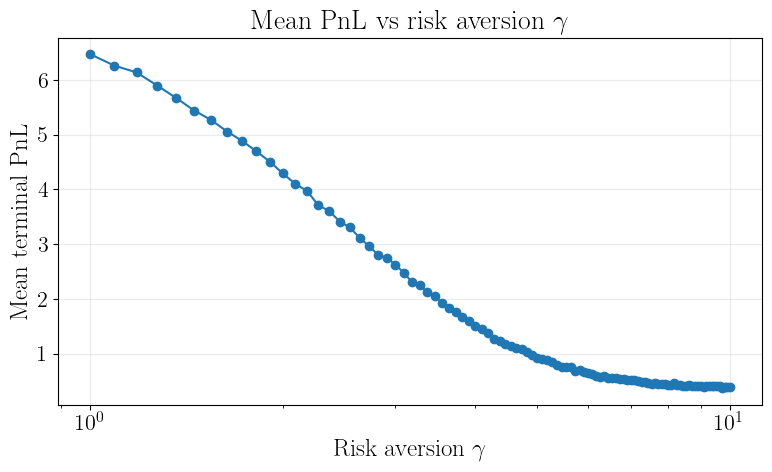

In [24]:
plt.figure(figsize=(8,5))
plt.plot(gammas, mean_pnl, marker="o")
plt.xlabel(r"Risk aversion $\gamma$")
plt.ylabel(r"Mean terminal PnL")
plt.title(r"Mean PnL vs risk aversion $\gamma$")
plt.grid(alpha=0.25)
plt.xscale("log")
plt.tight_layout()
plt.show()

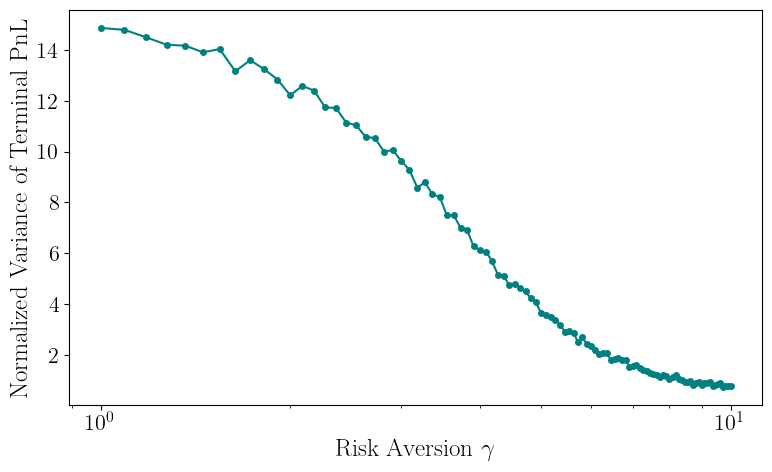

In [ ]:
benchmark = T * (sigma**2)
var_pnl_norm = var_pnl

plt.figure(figsize=(8,5))
plt.plot(gammas, var_pnl_norm, marker="o", markersize=4, color="teal")
plt.xlabel(r"Risk Aversion $\gamma$")
plt.ylabel(r"Normalized Variance of Terminal PnL")
# plt.title(r"PnL variance vs risk aversion $\gamma$")
plt.xscale("log")
plt.tight_layout()
# plt.savefig("Plots/pnl_variance_vs_gamma.png", dpi=300)
plt.show()

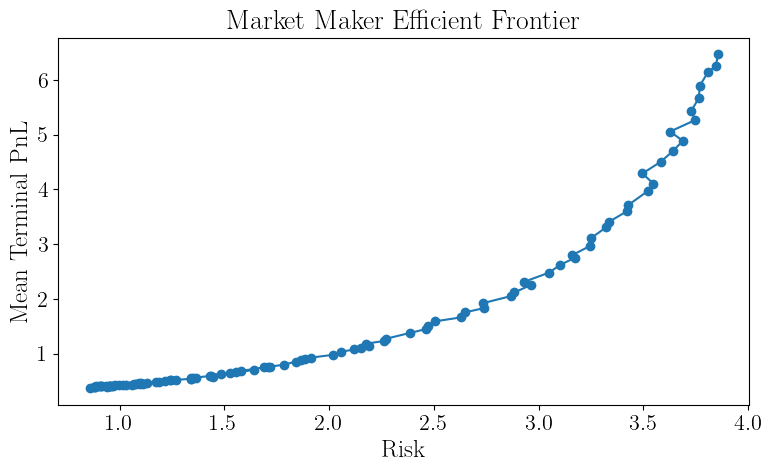

In [ ]:
std = np.sqrt(var_pnl)
plt.figure(figsize=(8,5))
plt.plot(np.sqrt(var_pnl), mean_pnl, marker="o")
plt.xlabel(r"Risk")
plt.ylabel(r"Mean Terminal PnL")
# plt.hlines([38.5], xmin=min(std), xmax=max(std), colors='r', linestyles='dashed')
plt.title(r"Market Maker Efficient Frontier")
plt.tight_layout()
plt.savefig("Plots/efficient_frontier.png", dpi=300)
plt.show()